# Catching the Drift:<br/>Modelling Coral Growth with Diffusion Limited Aggregation (DLA)
#### _Group 12: Esther Bakels (12362980), Loes Bijman (15211312), Aleksandar Jacimovic (15278247), Boyan Mihaylov (15067602)_

This notebook contains the code for the conducted experiments with simulated DLA "coral" clusters. **Section 2** exemplifies the use of the simulation tool by introducing a simple procedure to execute simulations with various parameters. The measurements of the fractal dimension and the branching distribution of a DLA cluster are demonstrated in **Sections 3 and 4**, respectively. **Section 5** illustrates the specific experimental setups which were used for the presented results. **Section 6** is used to analyse the results of these experiments and **Section 7** touches upon some extra functionality of the model which was not analysed in depth during the project.

## 1. Imports / Preliminaries

The building blocks of the framework are imported from several .py modules. The DLA model containing all functions defining the movement, aggregation, initialisation and regeneration of particles can be found in `dla_model.py`. The analysis of the fractal dimension and the branch distribution of DLA-generated "corals" are designated functions in `cs_measures.py`. The experimental setups for executing the simulations and analysing the results are defined as functions in `dla_simulation.py`. Matplotlib functions tend to create a bit of a mess, which is why we contained most of the plotting procedures in a separate module, `vis_tools.py`.

In [1]:
# Import packages
import numpy as np
import pandas as pd

# Import custom modules
import vis_tools as vt
import dla_model as dm
import dla_simulation as ds
import cs_measures as csm

from importlib import reload

The `reload` function is useful for refreshing the imported modules when changes have been made to the .py files.

In [115]:
# Reload modules
reload(vt)
reload(dm)
reload(ds)
reload(csm)

<module 'cs_measures' from 'd:\\Msc Computational Science\\S01P03\\Complex System Simulation\\00 Github\\complex-system-simulation\\Code\\cs_measures.py'>

## 2. Basic DLA Model

The code below is used to run single instances of the DLA "coral" growth. This cell can be used to quickly test different parameter configurations.

There is a general distinction between two types of parameters:
1. Temporal / spatial:
- lattice size $L$ in each dimension;
- time steps of the simulation;
- a boolean toggle determining whether the neighbourhood regime is Moore (True) or otherwise von Neumann (False);
- a tuple of periodicity toggles determining whether the lattice is periodic in a specific dimension (this tuple may resize depending on the assumed dimensions);
- a boolean toggle determining whether the particles are regenerated at the boundary to maintain a constant proportion of particles in the vacant spaces;
2. Environmental (analogical to natural phenomena affecting the growth).
- sun vector - a vector affecting the directional preference for attachment of new particles to the structure;
- drift vector - a vector affecting the direction bias and determinacy in the random walk of the particles;
- particle density - a proportion (value between 0 and 1) which either determines the initial concentration of particles on the lattice or, in case `regen_bndry` is `True`, a proportion of particles which is maintained in the vacant spaces at any time during the simulation.
- a number of seeds generated along a line at the bottom of the lattice, used in the seed-generating function `init_seeds_bottom`; seeds can also be explicitly supplied as a list of points (coordinate lists).

Some of these parameters are more thoroughly explained in **Section 5**.

It is important to note that the number of dimensions of the lattice is inferred from the number of coordinates in the supplied seeds which, in turn, can be specified in the seed initialisation function. So far only two and three-dimensional lattices have been successfully tested, but higher dimensions should also work in theory.

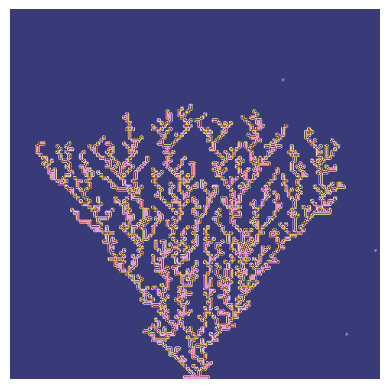

In [59]:
# Time / space parameters
size = 128
steps = 1000
Moore = True
periodic = (False, True)
regen_bndry = True

# Environment parameters
drift_vec = [-0.01, -0.5]
sun_vec = [0, -1]
particle_density = 0.1
n_seeds = 1
obstacle = None
multi_seed = False

# Initialize lattice
seeds = dm.init_seeds_bottom(size, n_seeds, n_dims=len(drift_vec))
lattice = dm.init_lattice(size, seeds)

# Initialize obstacle lattice
if obstacle is not None:
    # The obstacle boxes are defined as [x1, x2, y1, y2, z1, z2] (adapt for number of dimensions)
    boxes = np.array([[15,17,19,35,10,20], [40,45,50,55,60,55]])
    obstacle = dm.init_obstacle_lattice(size, boxes=boxes, seed_coords=seeds)

# Initialize particles
particles = dm.init_particles(lattice, particle_density, obstacles=obstacle)

# Arrays for storing time frames
lattice_frames = np.empty((steps,)+(size,)*len(drift_vec))
particles_frames = np.empty_like(lattice_frames)

current_lattice = np.array(lattice)
current_particles = np.array(particles)
for step in range(steps):
    
    # Record current state
    lattice_frames[step] = np.array(current_lattice)
    particles_frames[step] = dm.particles_to_lattice(current_particles, size)

    # Move particles
    current_particles = dm.move_particles_diffuse(current_particles, current_lattice, periodic=periodic, moore=Moore, obstacles=obstacle, drift_vec=drift_vec, regen_bndry=regen_bndry)

    # Aggregate particles
    current_lattice, current_particles = dm.aggregate_particles(current_particles, current_lattice, None, moore=Moore, obstacles=obstacle, sun_vec=sun_vec, multi_seed=multi_seed)
    # print(f"step {step}: {current_lattice}")

# Animate DLA cluster
# vt.animate_lattice(lattice_frames, interval=10)
    
# Animate DLA cluster with particles
vt.animate_lattice((lattice_frames*5 + particles_frames)/6, interval=10)

# Animate DLA cluster with particles and obstacles
# vt.animate_lattice((lattice_frames*5 + particles_frames + obstacle*2)/8, interval=10)

# Plot final frame only
# vt.plot_lattice(lattice_frames[-1], cell_size=2)

## 3. Fractal Dimension

The fractal dimension can generally be defined as the exponent by which the "mass" of a shape scales relative to a factor which scales the size of the shape regularly in space. Two approaches are explored in measuring this, both based on the Minkowski-Bouligand dimension using the box-counting method.

### 3.1. Coarse-graining Method

The first method relies on taking only the final DLA cluster, incrementally doubling the size of the lattice cells and counting how many of the coarse cells contain parts of the cluster.

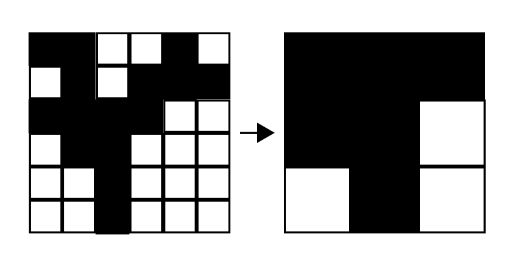

If $\epsilon$ is the length of the box at each iteration, then $1/\epsilon$ can be considered the "scaling factor" at each iteration, with the fractal dimension estimate $D$ arising from the following relationship:

$$
N(\epsilon) \approx C(1/\epsilon)^D
$$

where $N(1/\epsilon)$ is the number of occupied cells of size $\epsilon$. $D$ is found through a linear regression fit through a log-log plot of the scaling factors and the respective occupied box counts at each coarse-graining size, represented by the slope of the line.

This method imposes a constraint that the lattice size should always be a power of 2.

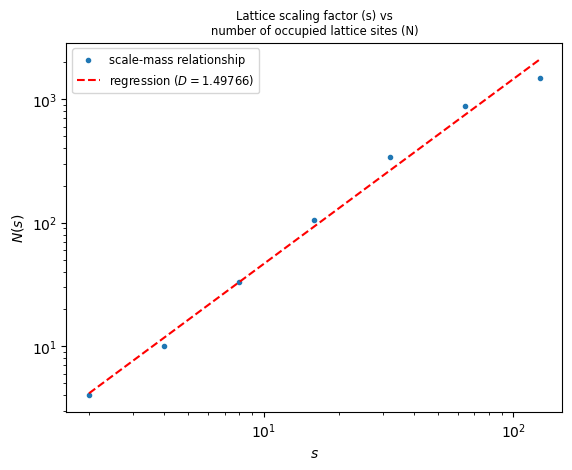

In [60]:
fractal_dims, scales, n_boxes, coeffs = csm.fractal_dimension_clusters(current_lattice, fit=True)
vt.plot_fractal_dimension(scales, n_boxes, coeffs)

### 3.2. Radius-based Scale

As the above measurement poses the risk of information loss when "pixelating" the DLA cluster, a second method is explored which relies on a constant tracking of the cluster scale as it grows. For this, the maximum distance between a single seed point and all occupied lattice cells is considered as the "radius" of the cluster. Under the assumption that the shape of the cluster grows uniformly over time, this radius should be representative of the uniform scaling factor needed for the fractal dimension calculation.

As will be seen later, the condition that the cluster grows equally in all dimensions does not always hold. Nonetheless, this method does provide more data points and potentially more accuracy for the more uniform DLA "coral" shapes.

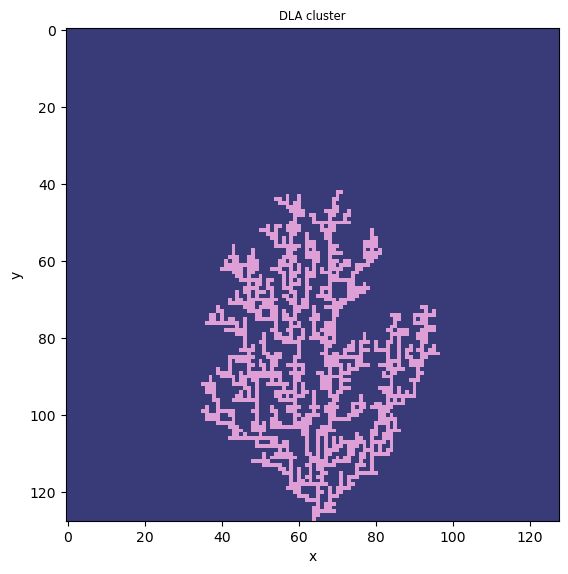

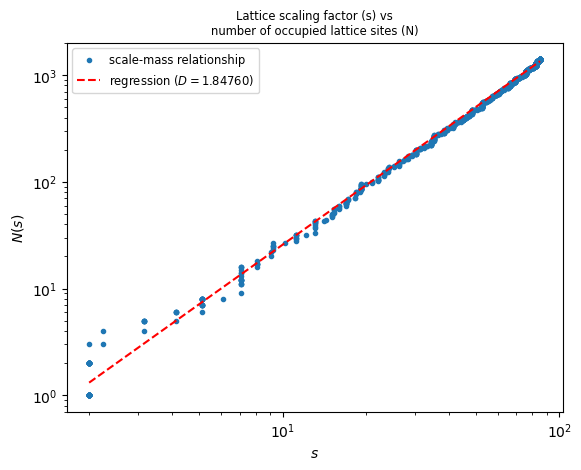

In [116]:
lattice_frames, particles_frames, dla_radii, seeds = ds.run_dla(128, 2000, 0.1, track_radius=True)
vt.plot_lattice(lattice_frames[-1], cell_size=1)
n_boxes = np.sum(lattice_frames, axis=(1,2), dtype=int)
fractal_dims, coeffs = csm.fractal_dimension_radius(dla_radii, n_boxes, fit=True)
vt.plot_fractal_dimension(dla_radii, n_boxes, coeffs)

## 4. Branch Distribution

In [ ]:
branch_lengths_unique, branch_length_counts, branches = csm.branch_distribution(current_lattice, seeds[0])
vt.plot_lattice(current_lattice, branches)
vt.plot_branch_length_distribution(branch_lengths_unique, branch_length_counts, branches)

## 5. Simulation Series

With all the foundations laid out, a series of simulations can be performed to explore the complex system measures outlined above. On one hand, this may lead to valuable insights on the behaviour of the algorithm itself. Secondly, a potential comparison of the results with real measurement data from coral shapes can be used for verification. Finally, if a morphological correspondence is found, the variation of the simulation parameters can be used to model actual variations in the environmental conditions of a coral.

A typical experiment usually requires a range of values to be defined for each parameter of interest. These parameter ranges, constructed as instances of `numpy.ndarray`, are brought together in any possible combination using `itertools.product` and the simulation framework iterates through each of these combinations, typically executing 30 simulations per combination as determined by the `n_sims` parameter.

Previous tests have shown that most of the simulations require less than half an hour to run. Should this not be the case, an easy solution would be to reduce the number of simulations per parameter combination `n_sims` to a manageable amount.

There are two types of termination conditions - a maximum of time steps per simulation and a target DLA cluster mass to be achieved. In order to have comparable measurements, it is normally advisable to fulfill the target mass condition before running out of time steps; otherwise, if such an event occurs, a warning is raised. A potential future development could determine an analytical derivation of the relationship between a target mass and the required number of time steps before it is reached. The analysis of mass growth over time included in these numerical studies may in fact point toward trends in this respect.

### 5.1. Lattice Dimensions / Neighbourhood Types

The first set of experiments are exploring the basic "world" parameters of the DLA model - the size and dimensions of the lattice and the type of neighbourhood for the perturbation and aggregation procedures. First, some common parameters shared among all simulations can be defined, as these will contain a single value and are of less importance for this initial study.

All of the following simulations start from a single seed and a limited budget of nutrients which expires throughout the simulation, hence `regen_mode` is set to `False`. All the relevant measures are recorded and the lattice space is defined as non-periodic in all dimensions, with particles being regenerated probabilistically at specific edges when they leave the bounds of the lattice, as opposed to wrapping around the grid.

In [ ]:
# Shared environment parameters
n_seeds_series = np.repeat(int(1), 1)
particle_density_series = np.array([0.1])
obstacle_box_series = np.array([None])

# Shared simulation parameters
fdim_measure = 'both' # fractal dimension, can be None / 'cgrain' / 'radius' / 'both
calc_branch_distr = True
calc_mass = True
periodic = (False, False)
regen_mode = None

#### 5.1.1. 2D / von Neumann

The first experiment looks into a relatively large two-dimensional lattice ($256\times 256$) and a von Neumann neighbourhood (i.e. 4 neighbours). The target DLA cluster mass is set to $5\%$ of the entire lattice area. The dimensions of the lattice are implied by the dimensions of the input drift and sun vectors.

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([256])
max_timesteps_series = np.array([5000])
target_mass_series = np.array([int(0.05 * lattice_size_series[0]**2)])
drift_vec_series = np.array([[0, -1]])
sun_vec_series = np.array([[0, -1]])

# Define fixed simulation parameters
move_moore = False
aggr_moore = False

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      obstacle_box_series=obstacle_box_series, drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

vt.plot_lattice(dla_evolutions['lattice_frames'][0][-1], cell_size=2)

sim_results

The results can be saved to a `.json` file for later use.

In [ ]:
sim_results.to_json('sim_results_2D_von_neumann.json')

#### 5.1.2. 2D / Moore

The second experiment explores the same lattice size and dimensions, this time with a Moore neighbourhood (8 neighbours).

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([256])
max_timesteps_series = np.array([5000])
target_mass_series = np.array([int(0.05 * lattice_size_series[0]**2)])
drift_vec_series = np.array([[0, -1]])
sun_vec_series = np.array([[0, -1]])

# Define fixed simulation parameters
move_moore = True
aggr_moore = True

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      obstacle_box_series=obstacle_box_series, drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

vt.plot_lattice(dla_evolutions['lattice_frames'][0][-1], cell_size=1)

sim_results

In [ ]:
sim_results.to_json('sim_results_2D_moore.json')

#### 5.1.3. 3D / von Neumann

Taking the step into three dimensions, the lattice size needs to be reduced to 64 due to memory allocation constraints. The next experiment explores a von Neumann neighbourhood on a 3D lattice, aiming for a target mass of $2.5\%$ of the total lattice volume.

In [ ]:
reload(ds)
reload(dm)

In [ ]:
# Define environment parameter series (3D setup)
lattice_size_series = np.array([64])
max_timesteps_series = np.array([12000])
target_mass_series = np.array([int(0.025 * lattice_size_series[0]**3)])
drift_vec_series = np.array([[0, 0, -1]])
sun_vec_series = np.array([[0, 0, -1]])

# Define fixed simulation parameters
move_moore = False
aggr_moore = False

# Run simulations
n_sims = 1
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      obstacle_box_series=obstacle_box_series, drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

vt.plot_lattice(dla_evolutions['lattice_frames'][0][-1], cell_size=1)

sim_results

In [ ]:
sim_results.to_json('sim_results_3D_von_neumann.json')

#### 5.1.4. 3D / Moore

Finally, the same setup is used under a Moore neighbourhood principle.

In [ ]:
# Define environment parameter series (3D setup)
lattice_size_series = np.array([64])
max_timesteps_series = np.array([12000])
target_mass_series = np.array([int(0.025 * lattice_size_series[0]**3)])
drift_vec_series = np.array([[0, 0, -1]])
sun_vec_series = np.array([[0, 0, -1]])

# Define fixed simulation parameters
move_moore = True
aggr_moore = True

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      obstacle_box_series=obstacle_box_series, drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

sim_results

In [ ]:
sim_results.to_json('sim_results_3D_moore.json')

### 5.2. Environmental Parameters

The following series of simulations focus on the effect of varying environmental parameters (drift vector, sun vector, nutrient density) on the morphological features of the simulated coral. As the possible parameter combinations are countless, we decided to structure this exploration into four separate experiments, each one exploring the variation in a particular parameter while keeping the others fixed or confined within a narrower range.

The parameters of interest in this case are:
- The magnitude of the sun vector $|\vec{s}|$ - influencing how much the growth is biased towards the direction of the sun;
- The magnitude of the drift vector $|\vec{d}|$ - influencing how much the Random Walk of the particles (nutrients) is biased in a specific direction;
- The angle of the drift vector $\theta_d$ - influencing the direction of the Random Walk bias, particularly in relation to the sun vector;
- The density of particles (nutrients) $p$.

For a more realistic setting, the nutrients do not expire as in the previous experiment but are rather regenerated at the edges in amounts needed to compensate the predefined particle density.

In [ ]:
reload(ds)
reload(dm)

#### 5.2.1. Varying Sun Vector Magnitude

The variation in the sun vector magnitude has the effect of altering the neighbourhood weights when determining whether a particle should attach to an occupied lattice site. Defining $\vec{n_i}$ as a vector from a lattice site to one of its $n$ neighbours ($i=0,...,n$), the probability of attachment to a specific neighbour site is defined by normalizing the weight $w_i$ of a neighbour, resulting from the dot product with the inverse of the sun vector $\vec{s}$:

$$
w_i = <\vec{n_i}, -\vec{s}> + 1
$$

Thus, a normalized sun vector pointing vertically downwards results in 0.5 probability of attachment to a top site, 0.25 probability for either of the side neighbours and 0 probability for the bottom site. If the sun vector has a small magnitude ($< 1$), adding 1 to the dot product results in a non-zero probability even for the sites which are on the "shadow" side of the coral. Alternatively, with an increasing sun vector magnitude, the site facing it will get an increasing dominance over the others, leading to a very directional growth.

One way to interpret this magnitude is in terms of how diffuse the light is under water. Depending on the depth, refraction, murkiness or reflectiveness of the surroundings there could be coral parts growing in less illuminated regions. Alternatively, this vector could be interpreted as the dominance of zooxanthelae photosynthesis as a survival factor over the direction of incoming nutrients.

The simulation is run with the following parameters:

| $L$ | $t_{max}$ | $n_s$ | $p$ | $m_t$           | $\theta_d$            | $\|\vec{d}\|$ | $\|\vec{s}\|$ |
|-----|-----------|-------|-----|-----------------|-----------------------|---------------|---------------|
| 128 | 10000     | 1     | 0.1 | $0.05\times L^2$| $[-\pi/2,-\pi/4,0]$   | 0.5           |**0.01 to 100**|

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([128])
max_timesteps_series = np.array([9000])
n_seeds_series = np.repeat(int(1), 1)
particle_density_series = np.array([0.1])
target_mass_series = np.array([0.05 * lattice_size_series[0] ** 2], dtype=int)
obstacle_box_series = np.array([None])

# Define drift and sun vector ranges
angle_range = np.linspace(-0.5*np.pi, 0, 3)
drift_vec_series = np.column_stack((0.5*np.cos(angle_range), 0.5*np.sin(angle_range))) # Varying angle vectors with norm 0.5
sun_vec_series = np.column_stack((np.zeros(9), -(10.0 ** np.arange(-2, 2.5, 0.5))))  # Vertical vector with varying magnitude

# Define fixed simulation parameters
fdim_measure = 'both' # fractal dimension, can be None / 'cgrain' / 'radius' / 'both
calc_branch_distr = True
calc_mass = True
periodic = (False, False, False)
move_moore = False
aggr_moore = False
regen_mode = 'edge'

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series, obstacle_box_series=obstacle_box_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

sim_results

In [ ]:
sim_results.to_json('sim_results_sun_vector_mag.json')

#### 5.2.2. Varying Drift Vector Magnitude

Analogous to the sun vector, the drift vector also affects neighbourhood probabilities based on the dot product with the neighbour vectors. This results in varying probability of perturbing the particles in either neighbour direction during their Random Walk. If the drift is strong (i.e. a magnitude >> 1), then a stronger bias will be put on the movement in that direction, completely excluding a movement in a direction opposite to the vector. Alternatively, if the magnitude is smaller than 1, the probabilities shift in a way which permits such opposing movement. For vector magnitudes approaching zero, the drift loses signifficance, equalizing the probability of moving in any direction.

The drift can be used to model a combination of underwater currents and the effect of gravity on the influx of nutrients.

The simulation is run with the following parameters:

| $L$ | $t_{max}$ | $n_s$ | $p$ | $m_t$           |**$\|\vec{d}\|$**| $\theta_d$            | $\|\vec{s}\|$ |
|-----|-----------|-------|-----|-----------------|-----------------|-----------------------|---------------|
| 128 | 8000      | 1     | 0.1 | $0.05\times L^2$|**0.01 to 100**  | $-\pi/4$              | 0.5           |

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([128])
max_timesteps_series = np.array([8000])
n_seeds_series = np.repeat(int(1), 1)
particle_density_series = np.array([0.1])
target_mass_series = np.array([0.05 * lattice_size_series[0] ** 2], dtype=int)
obstacle_box_series = np.array([None])

# Define drift and sun vector ranges
drift_vec_series = np.tile(- np.sqrt(0.5) * 10.0 ** np.arange(-2, 3), (2, 1)).T # Varying magnitude 45 degree vectors
sun_vec_series = np.array([[0, -0.5]])

# Define fixed simulation parameters
fdim_measure = 'both' # fractal dimension, can be None / 'cgrain' / 'radius' / 'both
calc_branch_distr = True
calc_mass = True
periodic = (False, False, False)
move_moore = False
aggr_moore = False
regen_mode = 'edge'

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series, obstacle_box_series=obstacle_box_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

sim_results

In [ ]:
sim_results.to_json('sim_results_drift_vector_mag.json')

#### 5.2.3. Varying Drift Vector Angle

The interest in exploring the variation of the drift vector angle $\theta_d$ arises from the question: What happens if the attachment preference and the predominant arrival direction of nutrients are not aligned? By keeping the sun vector fixed and altering the drift direction, the relationship between the two driving "forces" acting on the growth changes, potentially affecting the simulated coral morphology.

While the drift angle gradually changes from a purely vertical to a purely horizontal orientation, its magnitude is kept to 0.5, such that a non-zero probability is given to a "backward" motion.

The simulation is run with the following parameters:

| $L$ | $t_{max}$ | $n_s$ | $p$ | $m_t$           | $\|\vec{d}\|$ |**$\theta_d$**   | $\|\vec{s}\|$         |
|-----|-----------|-------|-----|-----------------|---------------|-----------------|-----------------------|
| 128 | 8000      | 1     | 0.1 | $0.05\times L^2$| 0.5           |**$-\pi/2$ to 0**| 0.5                   |

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([128])
max_timesteps_series = np.array([8000])
n_seeds_series = np.repeat(int(1), 1)
particle_density_series = np.array([0.1])
target_mass_series = np.array([0.05 * lattice_size_series[0] ** 2], dtype=int)
obstacle_box_series = np.array([None])

# Define drift and sun vector ranges
angle_range = np.linspace(-0.5*np.pi, 0, 5)
drift_vec_series = np.vstack((np.cos(angle_range), np.sin(angle_range))).T # Varying angle vectors with norm 1
sun_vec_series = np.array([[0, -0.5]])

# Define fixed simulation parameters
fdim_measure = 'both' # fractal dimension, can be None / 'cgrain' / 'radius' / 'both
calc_branch_distr = True
calc_mass = True
periodic = (False, False, False)
move_moore = False
aggr_moore = False
regen_mode = 'edge'

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series, obstacle_box_series=obstacle_box_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

sim_results

In [ ]:
sim_results.to_json('sim_results_drift_vector_angle.json')

#### 5.2.4. Varying Nutrient Density

The abundance of nutrient particles may affect the time for the development of a DLA cluster of a specific mass. It is also an interesting question whether a more massive influx of particles, perhaps combined with correlations caused by the limited lattice space, has any measurable effects on the simulated coral morphology. For this, a variation in the nutrient density is explored under a fixed sun magnitude of 0.5 and various drift vectors differing both in magnitude and in angle. With such a combination of parameters it is possible to explore the effect of the transport of different nutrient masses through space.

The parameters are as follows:

| $L$ | $t_{max}$ | $n_s$ | **p**           | $m_t$           | $\|\vec{d}\|$ |$\theta_d$       | $\|\vec{s}\|$         |
|-----|-----------|-------|-----------------|-----------------|---------------|-----------------|-----------------------|
| 128 | 8000      | 1     |**0.025 to 0.25**| $0.05\times L^2$| 0.01 to 100   |**$-\pi/2$ to 0**| 0.5                   |

In [ ]:
# Define environment parameter series (2D setup)
lattice_size_series = np.array([128])
max_timesteps_series = np.array([20000])
n_seeds_series = np.repeat(int(1), 1)
particle_density_series = np.linspace(0.02, 0.1, 5) # Varying nutrient density
target_mass_series = np.array([0.05 * lattice_size_series[0] ** 2], dtype=int)
obstacle_box_series = np.array([None])

# Define drift and sun vector ranges
drift_vec_mags = np.tile(-np.sqrt(0.5) * 10.0 ** np.arange(-2, 3), (2, 1)).T # Varying magnitude 45 degree vectors
angle_range = np.linspace(-0.5*np.pi, 0, 3)
drift_vec_angles = np.vstack((np.cos(angle_range), np.sin(angle_range))).T # Varying angle vectors with norm 1
drift_vec_series = np.concatenate((drift_vec_mags, drift_vec_angles)) #  Combine both vector series
sun_vec_series = np.array([[0, -0.5]])

# Define fixed simulation parameters
fdim_measure = 'both' # fractal dimension, can be None / 'cgrain' / 'radius' / 'both
calc_branch_distr = True
calc_mass = True
periodic = (False, False, False)
move_moore = False
aggr_moore = False
regen_mode = 'edge'

# Run simulations
n_sims = 30
sim_results, dla_evolutions = ds.analyse_dla_patterns(n_sims, lattice_size_series, max_timesteps_series, n_seeds_series, particle_density_series, target_mass_series,
                                                      drift_vec_series=drift_vec_series, sun_vec_series=sun_vec_series, obstacle_box_series=obstacle_box_series,
                                                      fdim_measure=fdim_measure, calc_branch_distr=calc_branch_distr, calc_mass=calc_mass,
                                                      n_saved_sims=1, periodic=periodic, move_moore=move_moore, aggr_moore=aggr_moore, regen_mode=regen_mode)

sim_results

In [ ]:
sim_results.to_json('sim_results_density.json')

## 6. Analyse Simulation Results

### 6.1. Analysing the Spatial Parameters

In [ ]:
sim_results_read = np.empty(4, dtype=object)
sim_results_read[0] = pd.read_json('results/sim_results_2D_von_neumann.json')
sim_results_read[1] = pd.read_json('results/sim_results_2D_moore.json')
sim_results_read[2] = pd.read_json('results/sim_results_3D_von_neumann.json')
sim_results_read[3] = pd.read_json('results/sim_results_3D_moore.json')

for sim_results in sim_results_read:
    ds.analyse_sim_results(sim_results, dla_evolutions=None, title_on=False)

### 6.2. Analysing the Environmental Parameters

#### 6.2.1. Sun Vector Magnitude

In [ ]:
data_sun_mag = pd.read_json('results/sim_results_sun_vector_mag.json')
ds.plot_environmental_results('sun_vec', data_sun_mag)

#### 6.2.2. Drift Vector Magnitude

In [ ]:
data_drift_mag = pd.read_json('results/sim_results_drift_vector_mag.json')
ds.plot_environmental_results('drift_vec', data_drift_mag)

#### 6.2.3. Drift Vector Angle

In [ ]:
data_drift_angle = pd.read_json('results/sim_results_drift_vector_angle.json')
ds.plot_environmental_results('drift_vec', data_drift_angle, drift_vec_angle = True)

#### 6.2.4. Nutrient Density

In [ ]:
data_density = pd.read_json('results/sim_results_density.json')
ds.plot_environmental_results('particle_density', data_density)

## 7. Extensions